# 5. Visium Breast cancer

We applied SECE to breast cancer data sequenced by Visium. Experts have annotated the results according to the H&E staining and obtained pathology annotation containing 4 phenotypes and 20 subdivisions, they were ductal carcinoma in situ/lobular carcinoma in situ (DCIS/LCIS), healthy tissue (Healthy), invasive ductal carcinoma (IDC), and tumor surrounding regions with low features of malignancy (Tumor edge). Raw data was download from https://www.10xgenomics.com/resources/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0.

## Load data

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import SECE
import torch
import numpy as np
import scanpy as sc
import random 

result_path = 'breast_cancer'
os.makedirs(result_path, exist_ok=True)

In [2]:
adata = sc.read('./data/breast_cancer.h5ad')

## Creating and training the model

In [3]:
sece = SECE.SECE_model(adata.copy(), 
                       result_path=result_path,
                       hvg = 2000,
                       dropout_rate=0.1,
                       dropout_gat_rate = 0.2,
                       device='cuda:0')

Likelihood: nb
Input dim: 2000
Latent Dir: 32
Model1 dropout: 0.1
Model2 dropout: 0.2


### AE Module of SECE

In [4]:
sece.prepare_data(lib_size='explog')

Library size: explog
Input normalize: True
Input scale: False
Hvg: 2000
(3798, 2000)


In [5]:
sece.train_model1(epoch1=50, plot=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


Model1 lr: 0.001
Model1 epoch: 50
Model1 batch_size: 128


In [6]:
adata1 = sece.predict_model1(batch_size=128)

### GAT Module of SECE

In [7]:
sece.prepare_graph(cord_keys=['x','y'], 
                   latent_key = 'X_CE',
                   num_batch_x=1, 
                   num_batch_y=1, 
                   neigh_cal='knn',
                   n_neigh=6,
                   kernal_thresh=1)

Batch 1: Each cell have 6.0 neighbors
Batch 1: Each cell have 6similar cells
All: Each cell have 6.0 neighbors
Graph cal: knn
knn: 6
kernal_thresh: 1


In [8]:
sece.train_model2(  lr_gat=0.01, 
                    epoch2=40, 
                    re_weight=1, 
                    si_weight=0.1, 
                    plot=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.54it/s]


Model2 lr: 0.01
Model2 epoch: 40
Model2 similar weight: 0.1


In [9]:
adata1 = sece.predict_model2()

## Spatial domains

### Clustering

In [10]:
SECE.cluster_func(adata1, clustering='mclust', use_rep='X_SE', cluster_num=20, key_add='cluster')

VSCode R Session Watcher requires jsonlite, rlang. Please install manually in order to use VSCode-R.
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 3798 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'annot_type', 'fine_annot_type', 'x', 'y', 'size', 'n_counts', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial', 'spatial1', 'X_CE', 'X_SE'
    layers: 'counts', 'expr'

### Visualization

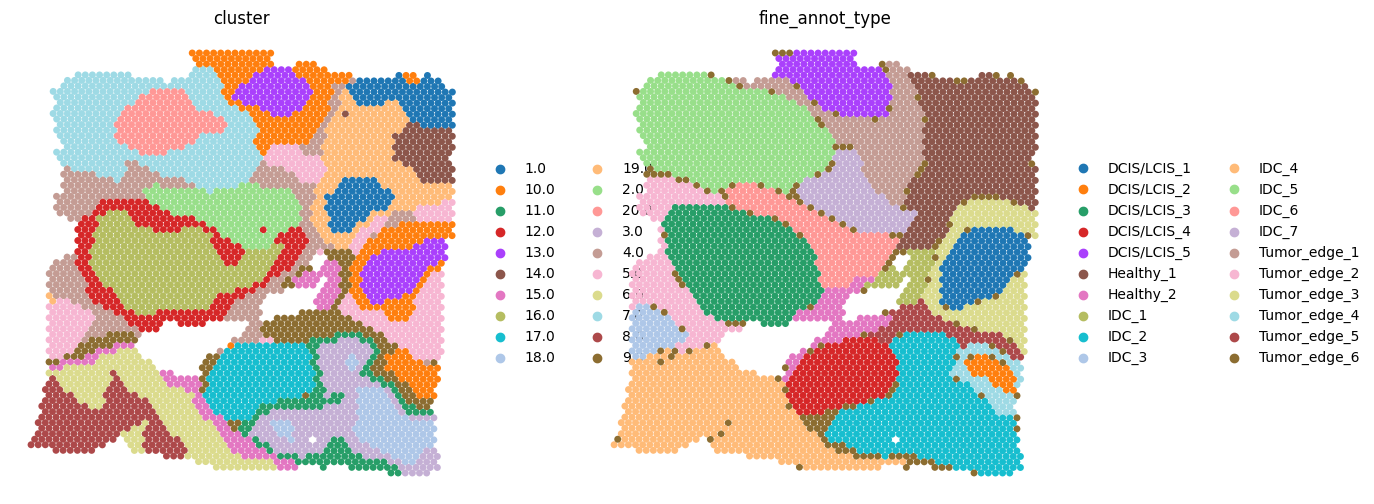

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (6,6)}):
    sc.pl.embedding(adata1, basis='spatial1', color=['cluster','fine_annot_type'],
                    frameon=False, size=100, show=True)

[<AxesSubplot: title={'center': 'cluster'}, xlabel='umap_SE1', ylabel='umap_SE2'>,
 <AxesSubplot: title={'center': 'fine_annot_type'}, xlabel='umap_SE1', ylabel='umap_SE2'>]

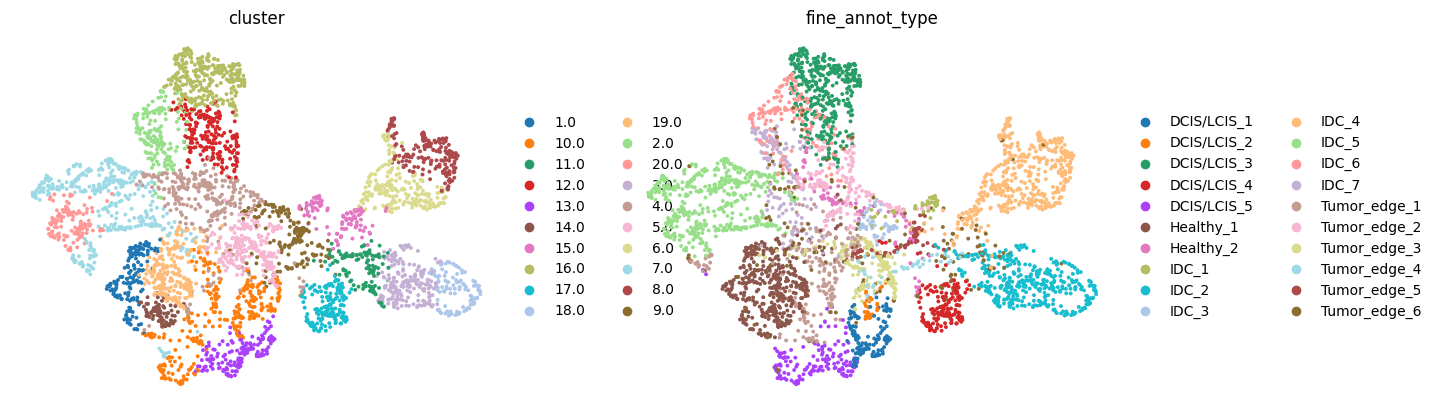

In [13]:
sc.pp.neighbors(adata1, use_rep='X_SE', key_added='X_SE')
adata1.obsm['umap_SE'] = sc.tl.umap(adata1, neighbors_key='X_SE', copy=True).obsm['X_umap']
sc.pl.embedding(adata1, basis='umap_SE', color=['cluster','fine_annot_type'],
                frameon=False, ncols=2, show=False)

In [14]:
adata1.write(f'{result_path}/adata1.h5ad')